### Requirements

In [3]:
!pip install -q -r requirements.txt


[notice] A new release of pip available: 22.2.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# reload modules before executing user code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from utils import set_random_seed

RANDOM_STATE = 42
set_random_seed(RANDOM_STATE)

### Data & Model

In [3]:
from huggingface_hub import hf_hub_download
import os

if os.path.exists('./checkpoints') == False:
    os.mkdir('./checkpoints')

vae_path = hf_hub_download(repo_id="stabilityai/sd-vae-ft-mse-original", filename="vae-ft-mse-840000-ema-pruned.safetensors", local_dir='./checkpoints')
realisticVision_path = hf_hub_download(repo_id="SG161222/Realistic_Vision_V5.1_noVAE", filename="Realistic_Vision_V5.1-inpainting.safetensors", local_dir='./checkpoints')

In [ ]:
from model import get_models, get_ddim_scheduler
text_encoder, vae, unet, tokenizer = get_models(
    realisticVision_path,
    vae_path,
    device="cuda:0",
    load_from_safetensor=True,
)

noise_scheduler = get_ddim_scheduler('stabilityai/stable-diffusion-2-inpainting')

In [6]:
from transformers import CLIPTextModel, CLIPTokenizer
tokenizer = CLIPTokenizer.from_pretrained(
    'stabilityai/stable-diffusion-2-inpainting',
    subfolder='tokenizer',
)

In [13]:
from dataset import SFTInpaintDataset

TRAIN_PATH = './data/train'
train_dataset = SFTInpaintDataset(
    TRAIN_PATH,
    tokenizer,
    global_caption=None,
    max_size=768,
    resize=True,
    normalize=True,
    noise_offset=0.1,
)

EVAL_PATH = './data/eval'
eval_dataset = SFTInpaintDataset(
    EVAL_PATH,
    tokenizer,
    global_caption=None,
    max_size=768,
    resize=True,
    normalize=True,
    noise_offset=0.1,
    seed=RANDOM_STATE,
)

In [14]:
from dataloader import SFTDataloader

train_batch_size = 8
eval_batch_size = 8

train_dataloader = SFTDataloader(
    train_dataset,
    tokenizer,
    batch_size=train_batch_size,
    shuffle=True,
)
eval_dataloader = SFTDataloader(
    eval_dataset,
    tokenizer,
    batch_size=eval_batch_size,
    shuffle=False,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


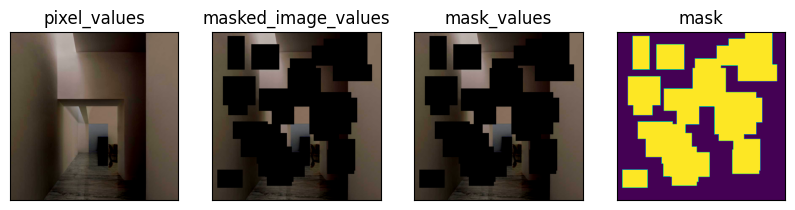

In [26]:
# plot some images
import matplotlib.pyplot as plt
import numpy as np

batch = next(iter(eval_dataloader))

# plot the batch
plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.title("pixel_values")
plt.imshow(batch["pixel_values"][1].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 2)
plt.title("masked_image_values")
plt.imshow(batch["masked_image_values"][1].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 3)
plt.title("mask_values")
plt.imshow(batch["mask_values"][1].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.subplot(1, 4, 4)
plt.title("mask")
plt.imshow(batch["mask"][1].permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

In [30]:
batch['pixel_values'].shape

torch.Size([8, 3, 512, 512])

### Training

In [ ]:
from training import SFTTrainer
from types import SimpleNamespace

config = SimpleNamespace(
    lr= 1e-4,
    weight_decay=0.0,
    epochs=100,
    val_epochs=10,
)

trainer = SFTTrainer(
    unet,
    vae,
    text_encoder,
    noise_scheduler,
    train_dataloader,
    eval_dataloader,
    device="cuda:0",
)

trainer.print_model_info()

In [ ]:
# require grad for just the unet parameters with attention
for name, param in unet.named_parameters():
    if "attentions" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
trainer.print_model_info()

In [ ]:
trainer.fit(config)